In [22]:
import sys
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
import numpy as np
import datetime as dt
import geopandas as gpd
import dendropy
import csv
from shapely.geometry import Point
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from pyproj import Proj,transform
import tqdm
import pandas as pd
from matplotlib import cm
import matplotlib
import matplotlib.ticker as plticker
import os
from statsmodels.stats.proportion import proportion_confint
from Bio import AlignIO
from Bio import SeqIO
from Bio.Seq import Seq
from datetime import date
import datetime
import csv
import baltic as bt
import collections
import math
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
import scipy
import matplotlib as mpl
import numpy as np
import matplotlib.lines as mlines
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from matplotlib.collections import PatchCollection
from epiweeks import Week, Year
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 18}
from matplotlib.lines import Line2D

mpl.rcParams.update({'font.size': 30})

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

plt.rcParams['font.family'] = 'Helvetica'

In [23]:
background_map = gpd.read_file("/Volumes/Ifeanyi/CladeII_ML/gadm41_SLE_2.json") #put the path your geojson in here - I recommend getting one from gadm.org.
#if you need to join different ones together, read them in like above, and then you can join them together like normal pandas dataframes.
#print(background_map)
background_map = background_map.to_crs("4326") #in the brackets you need to put in what coordinate system your sequences are in.
#it's usually EPSG:3395 or EPSG:4326 - if for DRC it's like -4.03,21.75 then it's EPSG:4326, if it's a higher number, try EPSG:3395
#if your dots end up in weird places, let me know because it's likely to do with this
kenya = background_map.loc[background_map["COUNTRY"] == "SierraLeone"]
#print(k)x

In [24]:
#these convert dates between each other and can be useful

def true_date(date):
    
    year = str(date).split(".")[0]
    decimal = f'0.{str(date).split(".")[1]}'
    
    if year == '2023' or year == '2024'or year == '2025':
        day_no = float(decimal) * 366
    else:
        day_no = float(decimal) * 365
        
    delta = dt.timedelta(day_no)
    
    start = dt.date(year=int(year), month=1, day=1)
    tr_date = start + delta
    
    return str(tr_date)

def decimal_date(date):
    
    if type(date) == str:
        date = dt.datetime.strptime(date,"%Y-%m-%d").date()
    year = date.year
    if year == 2020:
        div = 366
    else:
        div = 365
    start = dt.date(year=year, month=1, day=1)
    decimal = (date - start).days/div
    
    dec_date = year + decimal
    return dec_date

In [4]:
mcc_file = "/Volumes/Ifeanyi/CladeII_ML/SLE+cont+phy.mcc.tree" #input your mcc tree here
most_recent_sample =  #most recent sample in decimal format [you can get this from Beauti]

tree = dendropy.Tree.get(path=mcc_file, schema="nexus")

#first, name all of the nodes - currently all internal nodes don't have name
count = 0
for node in tree.preorder_node_iter():
    count += 1
    node.label = count

In [27]:
from collections import defaultdict
import csv
from shapely.geometry import Point
import tqdm

edge_dict = defaultdict(dict)
write_file = '/Volumes/Ifeanyi/CladeII_ML/SLE+cont+phy.mcc_Mpox_phylo.csv'  # output CSV path
point_lst = []

rows_out = 0
skipped_rows = 0

with open(write_file, 'w', newline='') as fw:
    writer = csv.DictWriter(
        fw,
        fieldnames=[
            "node1", "node2", "length",
            "start_long", "start_lat",
            "end_lat", "end_long",
            "start_dec_date", "end_dec_date",
            "start_real_date", "end_real_date",
            "end_location", "start_location"
        ]
    )
    writer.writeheader()

    for edge in tqdm.tqdm(tree.postorder_edge_iter(), desc="Processing edges"):
        if not edge.tail_node:
            continue

        node1 = edge.tail_node  # parent (older)
        node2 = edge.head_node  # child (younger)
        length = _to_float(getattr(edge, "length", None), default=0.0)

        # --- heights ---
        start_h = _get_height(node1)
        end_h   = _get_height(node2)

        # infer missing heights if possible
        if start_h is None and end_h is not None and length is not None:
            start_h = end_h + length
        if end_h is None and start_h is not None and length is not None:
            end_h = start_h - length
        if start_h is None or end_h is None:
            # cannot resolve heights, skip
            skipped_rows += 1
            continue

        # --- dates ---
        start_dec_date = most_recent_sample - start_h
        end_dec_date   = most_recent_sample - end_h
        start_real_date = true_date(start_dec_date)
        end_real_date   = true_date(end_dec_date)

        # --- coordinates ---
        start_lat, start_long = _get_coords(node1, background_map)
        end_lat, end_long     = _get_coords(node2, background_map)

        # skip edges with incomplete coordinates
        if None in (start_lat, start_long, end_lat, end_long):
            skipped_rows += 1
            continue

        # --- region lookup for reporting ---
        start_loc = None
        end_loc = None
        try:
            sp = Point(float(start_long), float(start_lat))
            ep = Point(float(end_long), float(end_lat))
            for location, polygon in zip(background_map["NAME_2"], background_map["geometry"]):
                if start_loc is None and polygon.contains(sp):
                    start_loc = location
                if end_loc is None and polygon.contains(ep):
                    end_loc = location
                if start_loc and end_loc:
                    break
        except Exception:
            pass

        # write to CSV
        writer.writerow({
            "node1": getattr(node1, "label", "") or "",
            "node2": getattr(node2, "label", "") or getattr(getattr(node2, "taxon", None), "label", "") or "",
            "length": length,
            "start_long": start_long,
            "start_lat": start_lat,
            "end_lat": end_lat,
            "end_long": end_long,
            "start_dec_date": start_dec_date,
            "end_dec_date": end_dec_date,
            "start_real_date": start_real_date,
            "end_real_date": end_real_date,
            "end_location": end_loc,
            "start_location": start_loc,
        })
        rows_out += 1

print(f"Wrote {rows_out} valid rows to {write_file}")
print(f"Skipped {skipped_rows} rows due to missing coordinates or heights.")


Processing edges: 499it [00:00, 6573.15it/s]

Wrote 407 valid rows to /Volumes/Ifeanyi/CladeII_ML/SLE+cont+phy.mcc_Mpox_phylo.csv
Skipped 91 rows due to missing coordinates or heights.


In [34]:
def safe_float(value):
    # Convert to float if possible, else return None
    try:
        return float(value)
    except (ValueError, TypeError):
        return None

def pull_from_existing_file(results_file):
    edge_dict = defaultdict(dict)
    with open(results_file) as f:
        data = csv.DictReader(f)
        count = 0
        for l in data:
            count += 1
            edge_dict[count] = {
                "start_lat": safe_float(l.get('start_lat')),
                "start_long": safe_float(l.get('start_long')),
                "end_lat": safe_float(l.get('end_lat')),
                "end_long": safe_float(l.get('end_long')),
                "start_dec_date": safe_float(l.get('start_dec_date')),
                "end_dec_date": safe_float(l.get('end_dec_date')),
                "start_real_date": l.get('start_real_date', '').strip(),
                "end_real_date": l.get('end_real_date', '').strip(),
                "length": l.get('length', '').strip()
            }
    # sort by end_dec_date but handle None
    edge_dict_sorted = {
        k: v for k, v in sorted(
            edge_dict.items(),
            key=lambda item: (item[1]["end_dec_date"] is not None, item[1]["end_dec_date"]),
            reverse=True
        )
    }
    return edge_dict_sorted

results_file = '/Volumes/Ifeanyi/CladeII_ML/SLE+cont+phy.mcc_Mpox_phylo.csv'
edge_dict = pull_from_existing_file(results_file)


In [40]:
#this will colour the nodes by date.

dates = []
for edge, edgedict in edge_dict.items():
    dates.append(edgedict["start_dec_date"])
    dates.append(edgedict["end_dec_date"])

    
norm = matplotlib.colors.Normalize(vmin=min(dates), vmax=max(dates))

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#F52765","#F52765", "#279FF5"]) #start, mid and end point of the colour map - you can change them whatever you like
colour_dict = {}
for date in dates:
    colour_dict[date] = cmap(norm(date))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 407/407 [00:01<00:00, 392.85it/s]


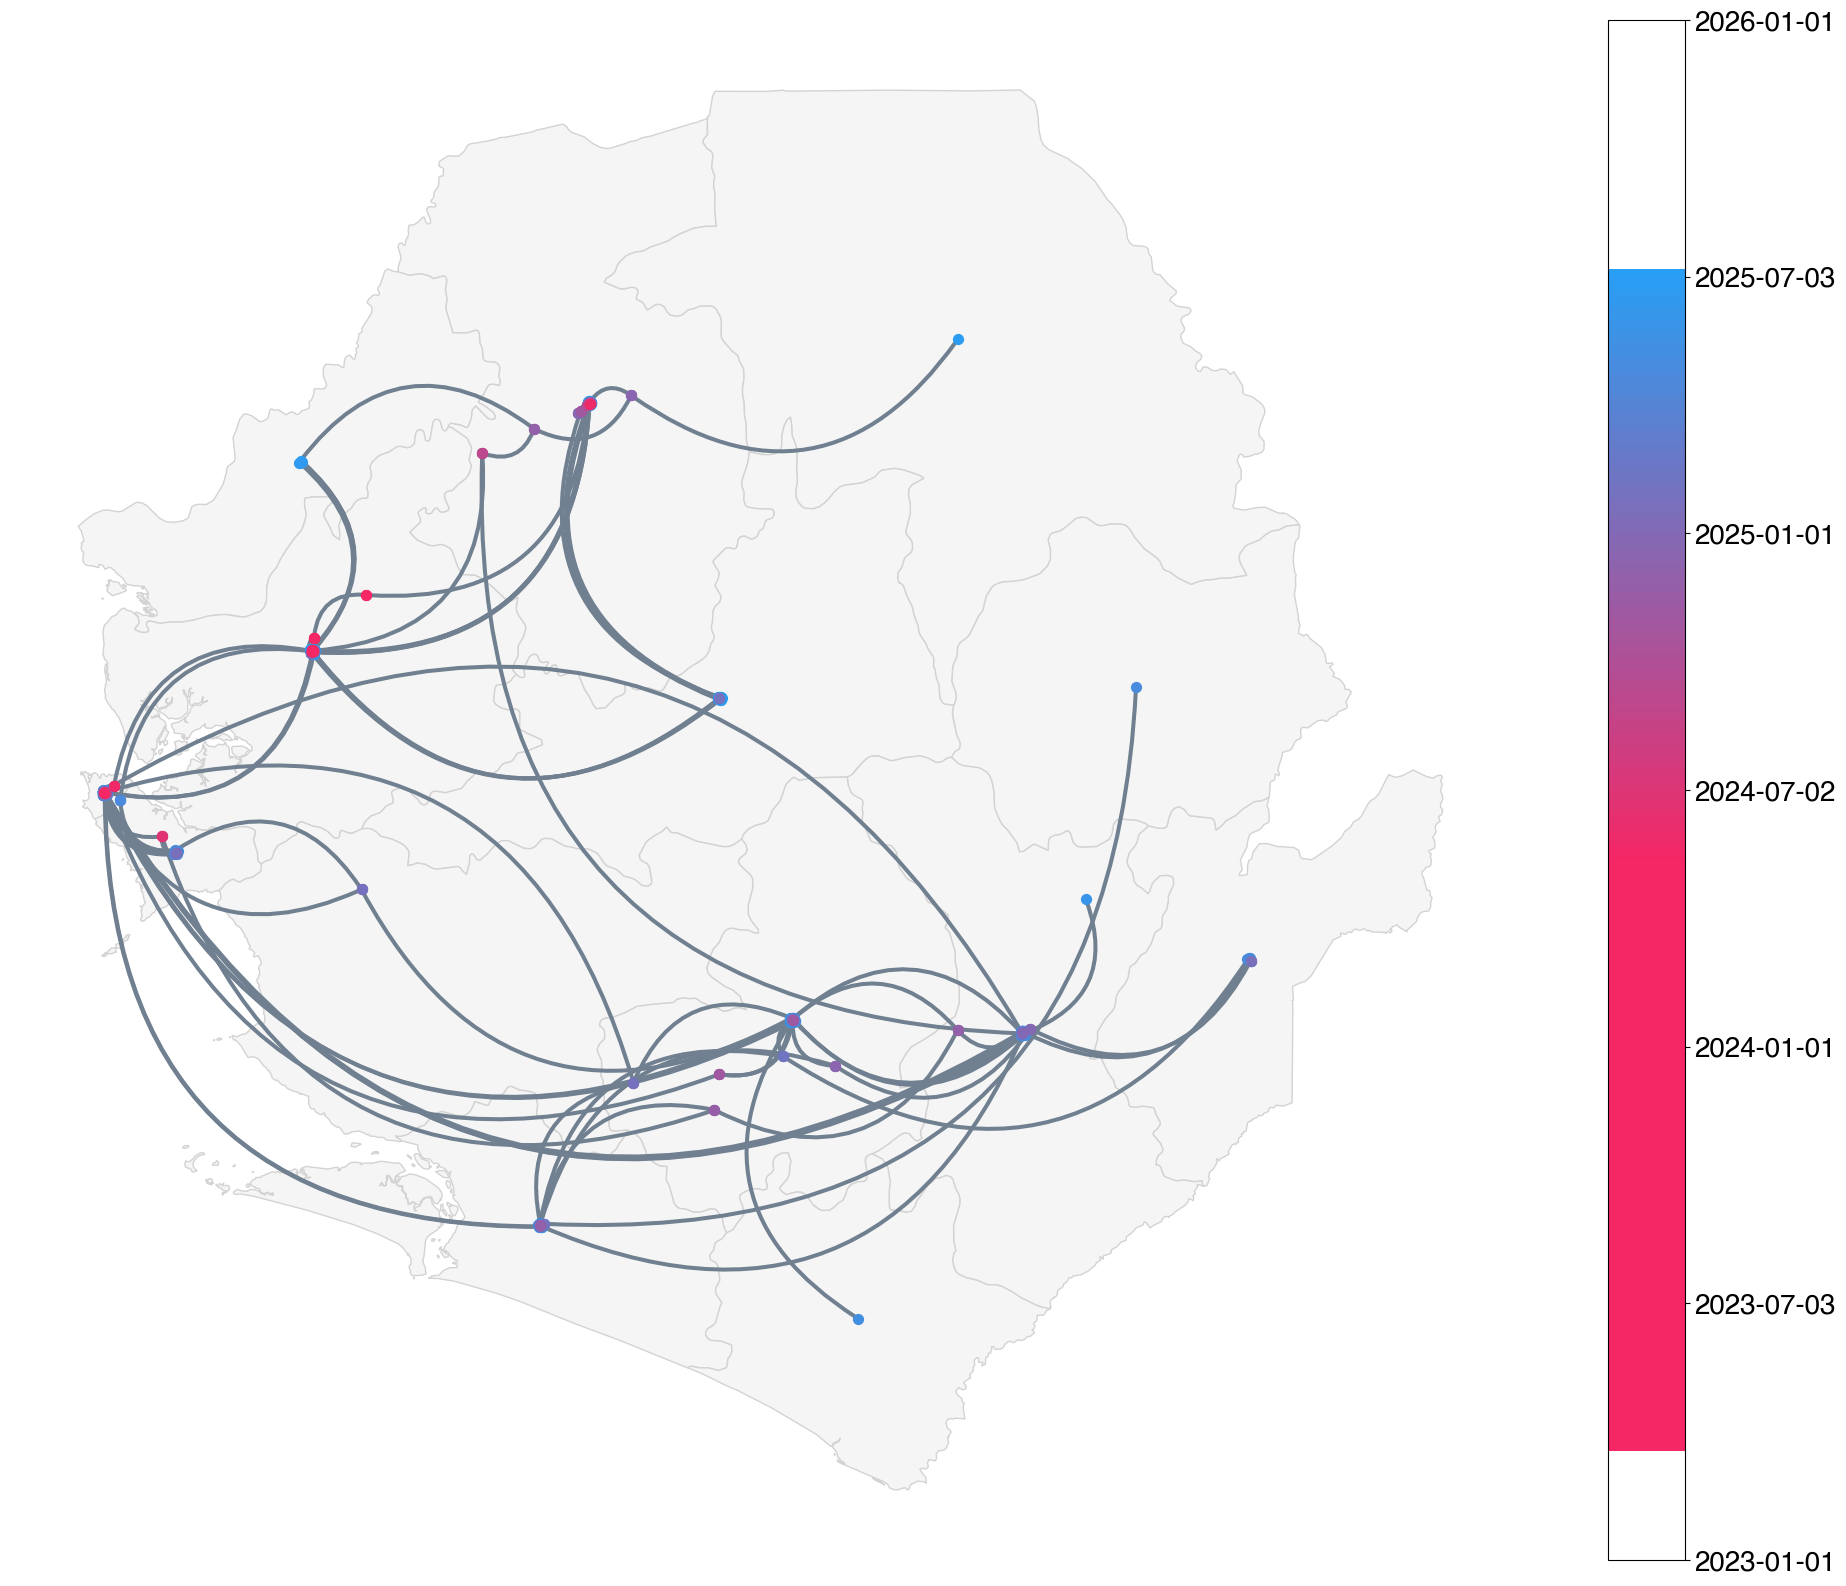

In [41]:
fig, ax = plt.subplots(1,1, figsize=(25,20))
matplotlib.rcParams.update({'font.size': 20})
#background_map["geometry"] = background_map.geometry.simplify(1000) #this smooths some edges so it's not too detailed for pdf readers

background_map.plot(ax=ax, color="whitesmoke", edgecolor="lightgrey") #this plots the background layer ie the shape of the countries
bar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
new_ticks = []
    
for i in bar.get_ticks():
    new_ticks.append(true_date(i))
bar.set_ticks(bar.get_ticks())
bar.set_ticklabels(new_ticks)
for edge, edgedict in tqdm.tqdm(edge_dict.items()): #loop through every branch and draw two dots and a line

    point_dict = defaultdict(list)

    A = edgedict["start_long"],edgedict["start_lat"]
    B = edgedict["end_long"],edgedict["end_lat"]
    start_date = edgedict["start_dec_date"]
    end_date = edgedict["end_dec_date"]

    #draw the line
    kw = dict(color="slategrey",linewidth=2.9)
    liney = mpatches.FancyArrowPatch(A, B, arrowstyle="-",
                             connectionstyle="arc3,rad=.5", **kw)
    ax.add_patch(liney)
    
    
        
    #draw the dots
    ax.scatter(A[0], A[1], s=50, color=colour_dict[start_date], alpha=1.0, zorder=5)
    ax.scatter(B[0], B[1], s=50, color=colour_dict[end_date], alpha=1.0, zorder=6)

ax.axis('off')
'/Volumes/Ifeanyi/CladeII_ML/SLE+cont+phy.mcc_Mpox_phylo.csv'
plt.savefig(f"/Volumes/Ifeanyi/CladeII_ML/SLE+continuous_phylogeography_map.png", bbox_inches='tight')
plt.savefig(f"/Volumes/Ifeanyi/CladeII_ML/SLE+continuous_phylogeography_map.pdf", bbox_inches='tight')
plt.savefig(f"/Volumes/Ifeanyi/CladeII_ML/SLE+continuous_phylogeography_map.svg", bbox_inches='tight')

In [45]:
import pandas as pd
import datetime

# --- user inputs ---
mrsd = 2025.5150684931507
lower_bound = 2024.606
upper_bound = 2025.5150684931507

# load your CSV
input_csv = "/Volumes/Ifeanyi/CladeII_ML/SLE+Persistence.csv"     # replace with your actual path
df = pd.read_csv(input_csv)

# compute persistence start
df["persistence_start_decimal"] = mrsd - df["persistenceTime"]

# filter to your sampling window
mask = (df["persistence_start_decimal"] >= lower_bound) & (df["persistence_start_decimal"] <= upper_bound)
filtered_df = df[mask].copy()

# convert decimal year to date
def decimal_year_to_date(decimal_year):
    year = int(decimal_year)
    rem = decimal_year - year
    start = datetime.date(year, 1, 1)
    days_in_year = (datetime.date(year+1, 1, 1) - start).days
    return start + datetime.timedelta(days=rem * days_in_year)

filtered_df["persistence_start_date"] = filtered_df["persistence_start_decimal"].apply(decimal_year_to_date)

# save filtered CSV
output_csv = "/Volumes/Ifeanyi/CladeII_ML/SLE+Persistence_filtered.csv"
filtered_df.to_csv(output_csv, index=False)

print(f"Filtered rows: {len(filtered_df)}")
print(f"Saved to {output_csv}")


Filtered rows: 1502
Saved to /Volumes/Ifeanyi/CladeII_ML/SLE+Persistence_filtered.csv


In [46]:
import pandas as pd

# --- input and output paths ---
input_csv = "/Volumes/Ifeanyi/CladeII_ML/SLE+MJhist.csv"        # replace with your file path
output_csv = "/Volumes/Ifeanyi/CladeII_ML/location_import_export_counts.csv"

# --- load data ---
df = pd.read_csv(input_csv)

# count exports (startLocation)
export_counts = df['startLocation'].value_counts()

# count imports (endLocation)
import_counts = df['endLocation'].value_counts()

# combine into a single DataFrame
all_locations = set(export_counts.index).union(import_counts.index)
summary = []

for loc in all_locations:
    summary.append({
        'Location': loc,
        'Exports': export_counts.get(loc, 0),
        'Imports': import_counts.get(loc, 0)
    })

summary_df = pd.DataFrame(summary)

# sort by location (optional)
summary_df = summary_df.sort_values(by='Location').reset_index(drop=True)

# save to CSV
summary_df.to_csv(output_csv, index=False)

print(f"Summary written to {output_csv}")
print(summary_df.head())

Summary written to /Volumes/Ifeanyi/CladeII_ML/location_import_export_counts.csv
   Location  Exports  Imports
0        Bo     1698    57730
1   Bombali    13833    39848
2    Bonthe     4177    47233
3  Kailahun      446    12586
4    Kambia      349    12386


/var/folders/tm/hjf14whs1xz0p1vxx3r7s95c0000gp/T/ipykernel_37117/3288999313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df["Export_prop"] = top_df["Exports"] / top_df["Total"]
/var/folders/tm/hjf14whs1xz0p1vxx3r7s95c0000gp/T/ipykernel_37117/3288999313.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df["Import_prop"] = top_df["Imports"] / top_df["Total"]


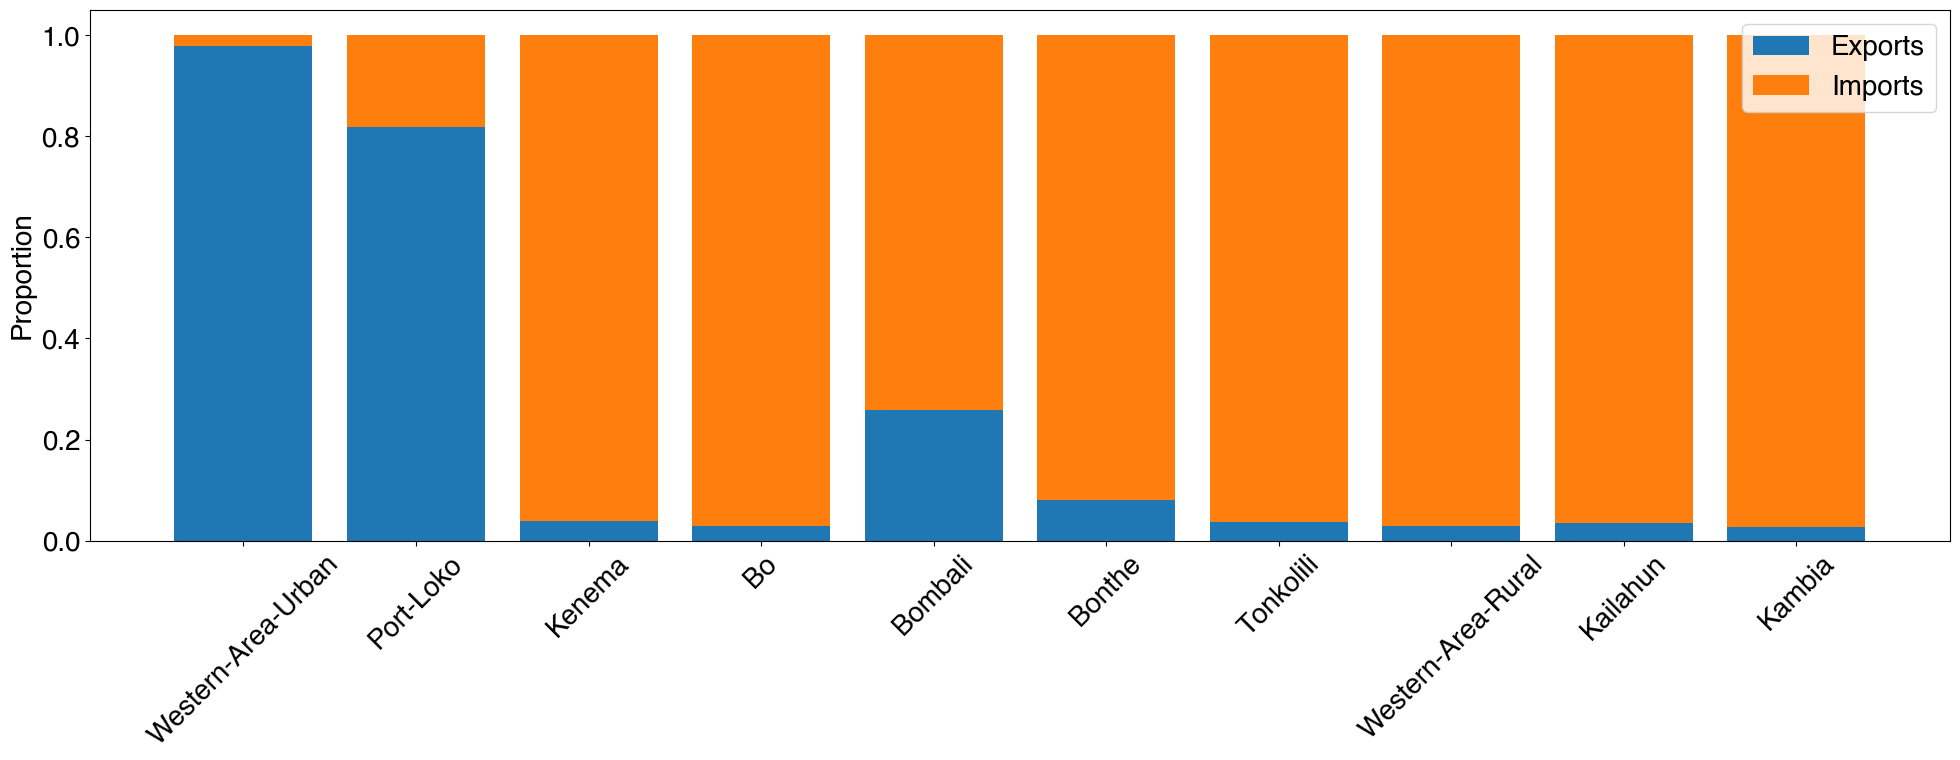

'/Volumes/Ifeanyi/CladeII_ML/normalized_import_export_stacked.png'

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

# Using the same data as before
data = {
    "Location": ["Western-Area-Urban", "Port-Loko", "Bombali", "Bonthe", "Kenema", "Bo",
                 "Tonkolili", "Koinadugu", "Western-Area-Rural", "Kailahun", "Pujehun",
                 "Kambia", "Kono", "Tongo"],
    "Exports": [243864, 71139, 13833, 4177, 3355, 1698, 1081, 951, 785, 446, 382, 349, 284, 241],
    "Imports": [5147, 15847, 39848, 47233, 83513, 57730, 28939, 2872, 27177, 12586, 3105, 12386, 3100, 3102]
}

df = pd.DataFrame(data)

# Sort and select top locations by total movements
df["Total"] = df["Exports"] + df["Imports"]
df = df.sort_values("Total", ascending=False).reset_index(drop=True)
top_df = df.head(10)  # highlight top 10 for clarity

# Normalize to proportions
top_df["Export_prop"] = top_df["Exports"] / top_df["Total"]
top_df["Import_prop"] = top_df["Imports"] / top_df["Total"]

# Plot stacked normalized bars
plt.figure(figsize=(20,8))
x = range(len(top_df))
plt.bar(x, top_df["Export_prop"], label="Exports")
plt.bar(x, top_df["Import_prop"], bottom=top_df["Export_prop"], label="Imports")
plt.xticks(x, top_df["Location"], rotation=45)
plt.ylabel("Proportion")
plt.title("")
plt.legend()
plt.tight_layout()

# Save figure
output_file = "/Volumes/Ifeanyi/CladeII_ML/normalized_import_export_stacked.png"
plt.savefig(output_file, dpi=300)
plt.show()

output_file